In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

jobs = pd.read_pickle(r'Notebooks/jeff-jobs-cleaned-2025.pkl')
supply = pd.read_pickle(r'Notebooks/jeff-supply-cleaned-2025.pkl')

# Relationship Between Hours Worked and Days Elapsed
<pre>
There is no linear relationship. 

This tells that days_elapsed likely has little to do with the difficulty of the job.
Could focus efforts into delays that cause a job to go unfinished.

Are these jobs being forgotten about, waiting on supplies, simply deemed unimportant? There are many possibities,
but I find this lack of a relationship notable. 
<pre>

In [2]:
filtered_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['hours_worked_flag'] != True) & (jobs['days_elapsed'].notna())] #23311 records 

filtered_jobs['days_elapsed'].corr(filtered_jobs['total_hours_worked']).round(4) #-0.0565

-0.0565

# Hours Worked By Equipment Nomenclature

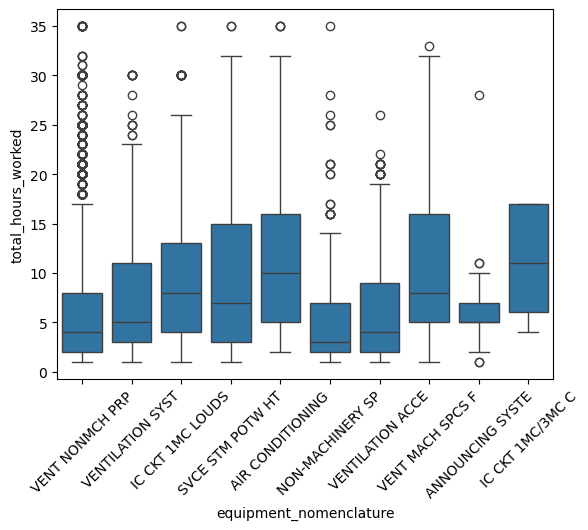

In [3]:
top10 = filtered_jobs['equipment_nomenclature'].value_counts().nlargest(10).index
df_top10 = filtered_jobs[filtered_jobs['equipment_nomenclature'].isin(top10)]

sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', data = df_top10)
plt.xticks(rotation = 45)
plt.show()
#All have at least 188 records
#Shows some sign of relationship between equipment being worked on and # of hours required to complete MA 


In [4]:
#Simple Linear Regression Using Equipment Nomenclature to Predict total_hours_worked
df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
model = ols('total_hours_worked ~ C(equipment_nomenclature)', data = df_top10).fit()
#model.rsquared = .045

#ANOVA
#Null: No differences between the means of individuals groups
#H1: Difference between at least 2 groups means
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                  sum_sq       df          F         PR(>F)
C(equipment_nomenclature)   27644.521118      9.0  84.332587  7.283757e-154
Residual                   584328.031302  16043.0        NaN            NaN


C:\Users\carswje\AppData\Local\Temp\ipykernel_13148\1422143295.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', ..., 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP']
Length: 16053
Categories (10, string): [AIR CONDITIONING, ANNOUNCING SYSTE, IC CKT 1MC LOUDS, IC CKT 1MC/3MC C, ..., VENT MACH SPCS F, VENT NONMCH PRP, VENTILATION ACCE, VENTILATION SYST]' has dtype incompatible with string, please explicitly cast to a compatible dtype first.
  df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')


<pre>
Very little predictive power using equipment_nomenclature to predict total_hours_worked
<pre>

# Relationship between when discovered, cause, deferral reason and days_elapsed

In [5]:
model = ols('days_elapsed ~ C(cause_code) + C(when_discovered_code) + C(deferral_reason_code)', data = jobs).fit()
model.summary() #R2 = 0.134
#also considered fitting with filtered_jobs, make a difference of .001 to r2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           days_elapsed   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     214.0
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:40:26   Log-Likelihood:            -2.3468e+05
No. Observations:               36117   AIC:                         4.694e+05
Df Residuals:                   36090   BIC:                         4.696e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        289.6083      3.553     81.509      0.000     282.644     296.572
C(cause_code)[T.1]               -48.4066      7.605     -6.365      0.000     -63.313     -33.500
C(cause_code)[T.2]               -38.3087      7.310     -5.240      0.000     -52.637     -23.980
C(cause_code)[T.3]               -99.8093      8.267    -12.074      0.000    -116.012     -83.606
C(cause_code)[T.4]               -15.6144     22.661     -0.689      0.491     -60.032      28.803
C(cause_code)[T.5]              -143.2290     11.958    -11.977      0.000    -166.668    -119.790
C(cause_code)[T.6]               -17.7649      6.940     -2.560      0.010     -31.368      -4.161
C(cause_code)[T.7]               -52.9903      2.407    -22.019      0.000     -57.707     -48.273
C(cause_code)[T.8]                 1.0537      4.747      0.222      0.824      -8.250      10.358
C(when_discovered_code)[T.1]    -148.4250     10.015    -14.820      0.000    -168.055    -128.795
C(when_discovered_code)[T.2]    -136.2487      4.578    -29.761      0.000    -145.222    -127.275
C(when_discovered_code)[T.3]    -104.4767      8.036    -13.001      0.000    -120.228     -88.726
C(when_discovered_code)[T.4]     -58.4116      4.418    -13.221      0.000     -67.071     -49.752
C(when_discovered_code)[T.5]    -145.0412     33.101     -4.382      0.000    -209.921     -80.162
C(when_discovered_code)[T.6]    -149.2143      4.797    -31.103      0.000    -158.618    -139.811
C(when_discovered_code)[T.7]    -148.7986     33.780     -4.405      0.000    -215.009     -82.588
C(when_discovered_code)[T.8]    -114.0705     16.337     -6.982      0.000    -146.092     -82.049
C(when_discovered_code)[T.9]    -145.4510      5.391    -26.980      0.000    -156.018    -134.884
C(deferral_reason_code)[T.1.0]     9.8201      3.328      2.950      0.003       3.296      16.344
C(deferral_reason_code)[T.2.0]   -10.1625      3.226     -3.151      0.002     -16.485      -3.840
C(deferral_reason_code)[T.3.0]     8.3524      5.815      1.436      0.151      -3.045      19.750
C(deferral_reason_code)[T.4.0]   -38.3974     17.538     -2.189      0.029     -72.771      -4.023
C(deferral_reason_code)[T.5.0]    51.3935     14.802      3.472      0.001      22.382      80.405
C(deferral_reason_code)[T.6.0]    33.0524      3.722      8.879      0.000      25.756      40.349
C(deferral_reason_code)[T.7.0]    25.9416     14.462      1.794      0.073      -2.405      54.288
C(deferral_reason_code)[T.8.0]    77.4219      4.572     16.932      0.000      68.460      86.384
C(deferral_reason_code)[T.9.0]    13.5732     20.383      0.666      0.505     -26.379      53.525
==============================================================================
Omnibus:                     6373.

# Priority 
<pre>
Desirable: 46737
Highly desirable: 503
Essential: 95
Mandatory: 15

Most records in this dataset refer to MAs where it is urgent to be completed quickly.
<pre>

# Number of Jobs Opened by Month for CVN 74

Text(0.5, 1.0, 'Jobs Opened By Month On CVN 74')

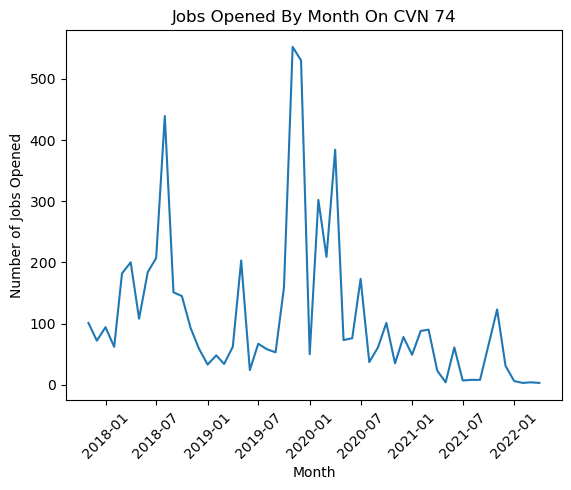

In [6]:
cvn74 = jobs[jobs['ship'] == 'CVN74'] 

monthly_counts = cvn74.groupby(cvn74['date_maintenance_action'].dt.to_period('M')).size() #Number of jobs opened each month on CVN74

monthly_counts.index = monthly_counts.index.to_timestamp() #Handles TypeError: float() argument must be a string or a real number, not 'Period'

plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel("Number of Jobs Opened")
plt.title("Jobs Opened By Month On CVN 74")

<pre>
There appears to be some meaningful variation from month to month.
Could look into trends/changes during busier or slower times
Specifically, do jobs take longer to complete during busier times?
<pre>

In [7]:
#Ideas Related to Time and The Number of Jobs Being Worked On Over Time


#Add variable showing # of jobs going on at the beginning of the MA 
#Add variable showing # of jobs that occur with the interval of the MA (date_maintenance_action ---> date_closing)
#For these variables, need to look at the job's ship. Also could look to subset further to work_center

# Next Ideas
<pre>
Predict when_discovered, cause, or deferral_reason
Cases for Each:

deferral_reason: Relatively balanced variable
Knowing why jobs get deferred in advance could help forecast for given types of jobs.
As specific personnel and work centers have specialties, additional information about why a job most often gets pushed back could help personnel plan. 
For example, knowing that a type of job often gets delayed for lack of material could lead to more effort towards montoring supply counts.


cause: Knowing the cause for a type of variable can help us enhance efforts in these areas. 
Cons: Normal wear and tear and Other make up the majority of the records for this variable. 

when_discovered: 
Relatively balanced 
Also, the top 2 most frequent are insightful - Normal operation and during inspection


Predict Engineered Variable: Binary, supplies required (Y/N)

Predict Engineered Variable: Job Took Longer than 8 hours to Complete (Y/N)
<pre>

# Idea: Predict deferral_reason
<pre>
Variables that Could Be Meaningful Predictors:

ship
cause_code
csmp_narrative_summary, equipment_nomenclature
location
priority_code, safety_code, status_code, component_status
when_discovered_code
work_center 
def_narrative, nondef_narrative
type_of_availability_needed


Number of jobs open at that time: One level is Due to ships' force work backlog
<pre>

# Ideas for Enhancing Text Features
<pre>
equipment_nomenclature, csmp_narrative_summary: Vectorization and then grouping most similar entries. Idea: reduce categories from >2100 to ~ 100
def_narrative
<pre>

# Plotting The Distribution for Hours Worked

0.311

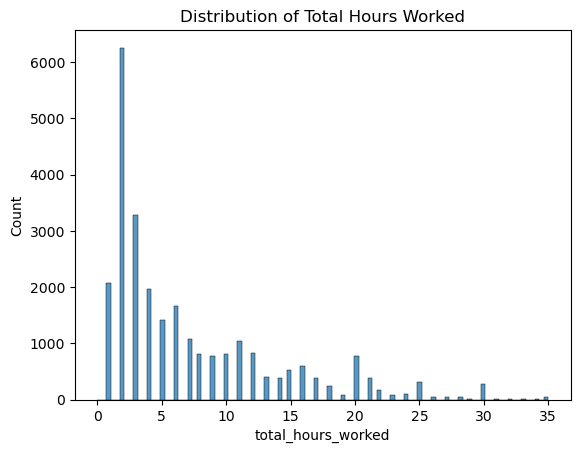

In [8]:
traditional_jobs = jobs[(jobs['hours_worked_flag'] != True) & (jobs['job_status'] != 'Open')]  #~ 27k records
#Only consider closed jobs that did not have outlier hours worked
sns.histplot(data=traditional_jobs, x='total_hours_worked', bins=100)
plt.title("Distribution of Total Hours Worked")

#Most jobs only take a few hours

#Considering jobs that did not have outlier hours worked, 31.1% of jobs took more than 8 hours to complete
(traditional_jobs['total_hours_worked'] > 8).mean().round(3)

# Plotting the Distribution of Days Elapsed

0.631

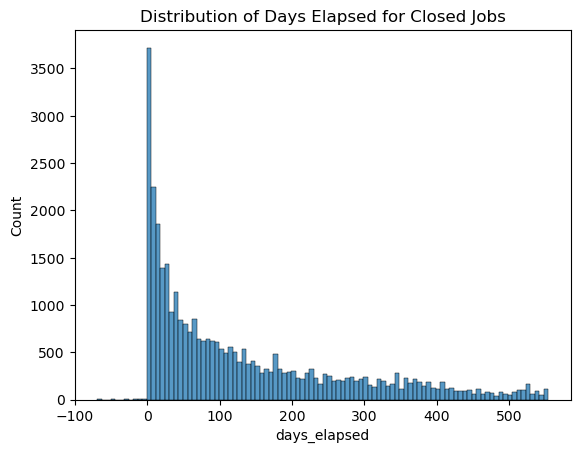

In [9]:
closed_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['job_status'] != 'Open')]  #~ 38k records

#Only consider closed jobs that were completed
sns.histplot(data=closed_jobs, x='days_elapsed', bins=100)
plt.title("Distribution of Days Elapsed for Closed Jobs")

(closed_jobs['days_elapsed'] > 30).mean().round(3) #55% of closed jobs took more than 50 days to complete
#76% of closed jobs took more than 10 days to complete

# Takeaway
<pre>
63% of closed jobs take over 30 days to become closed. This is when we remove days_elapsed outliers and only consider Closed jobs.
However, less than a third of the jobs take more than 8 hours (a full work day) to complete.

We could also see from the plots that there is a discrepency between the number of days elapsed and the total number of hours worked.

Also, deferral_reason_code:
35% due to lack of material
24% due to ship's force work backlog/operational priority
14% other/NA
13% lack of facilities/ capabiltiies
10% For ship's force overhaul

It seems that a bulk of the time spent for jobs to be closed is due to supply wait time or operational backlog.

Factors influencing operational backlog: Number of concurrent jobs being worked on
Factors influencing supply wait time: The types of parts being ordered, the quantity of parts, where parts are being ordered from, when the parts are ordered. 

<pre>

# -------------------------------Supply EDA------------------------------------

# Relationship between Supply Days Waiting and Total Days Elapsed

In [10]:
#There are multiple part orders associated with a job. We should look at the one that takes the longest to complete, making the assumption
#that a job cannot be completed until all parts have been received. 

In [11]:
supply_sub = supply[(supply['valid_dates'] == True) & (supply['supply_days_waiting_outlier'] == False)]
supply_sub = supply_sub[['job_seq','date_maintenance_action','demand_date','issue_date','date_closing','supply_days_waiting']]

supply_sub['total_days'] = supply_sub['date_closing'] - supply_sub['date_maintenance_action']
supply_sub['total_days'] = supply_sub['total_days'].dt.days

supply_sub['total_days'].corr(supply_sub['supply_days_waiting']).round(3)

0.238

# Plotting Supply Wait Time Vs. Total Job Time

Text(0.5, 1.0, 'Supply Wait Time Vs. Total Job Time')

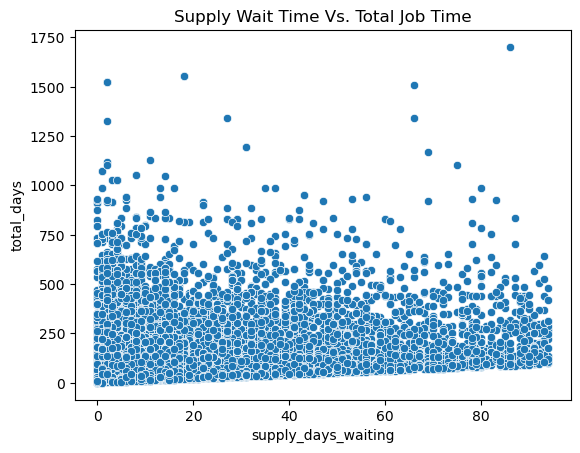

In [16]:
#supply_sub only considers records with valid dates (date open, demand date, issue date, date close in that order) and
#ignores outlier values for supply days waiting

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_sub)

plt.title('Supply Wait Time Vs. Total Job Time')

0.315

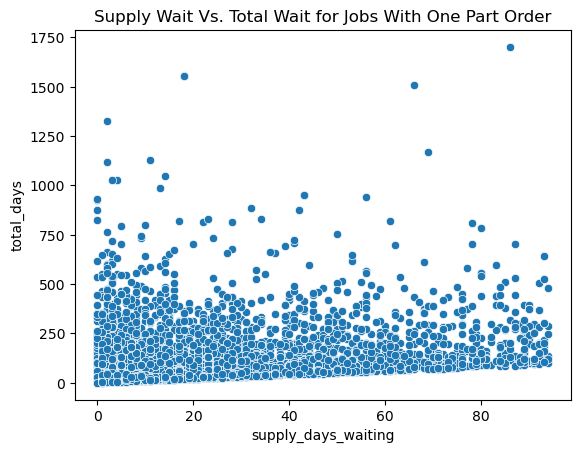

In [19]:
# Lets look only at rows where job_seq is present once. 
#see if there is any relationship

#having multiple part orders may add noise.
#if any sign of a relationship, could look into group by operations to only conisder longest time to arrive part
unique_jobs = supply_sub['job_seq'].value_counts()
unique_jobs = unique_jobs[unique_jobs == 1].index

supply_unique = supply_sub[supply_sub['job_seq'].isin(unique_jobs)]

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_unique)
plt.title('Supply Wait Vs. Total Wait for Jobs With One Part Order')

supply_unique['supply_days_waiting'].corr(supply_unique['total_days']).round(3) #0.315